### **Deep Learning Group Project 23-24**

##### **Group 5**

**Elements**:
- ...
- ...
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- ...
- ...


**In this notebook:**
1. ... *describe main objectives of the notebook*
2. ...
3. ...


**Index**
1. Data Imports <>
2. ... <>

In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# *********************************
# Library Imports
# *********************************

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # trying to mute tf's warnings (not working)

import time
import pickle
import shutil
import itertools
from functools import partial
from typing import Union, Generator

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard, # type: ignore
                                        ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy, AUC  # type: ignore
from tensorflow.keras import regularizers  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

import keras_tuner as kt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from utils.constants import CLASS_INT_TO_STR, MALIGN_DISEASES
from utils.visuals import ModelVisualEvaluation, SampleVisuals
from utils.gradcam import GradCAM, read_image_to_array

# constants
SEED = 42

TRAIN_PATH = os.path.join('data', 'train')
VAL_PATH = os.path.join('data', 'val')
TEST_PATH = os.path.join('data', 'test')

MODELS_PATH = os.path.join('model_dir', 'models')
HISTORIES_PATH = os.path.join('model_dir', 'history')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Utilitary Functions**

In [61]:
# *********************************
# Importing image data
# *********************************

# making this a function instead of importing
# straight away to add flexibility in the future
# we might want to train models with different
# batch sizes or image sizes

def import_data(*
                batch_size: int,
                image_size: tuple,
                rescale: bool = True,
                train_path: str = TRAIN_PATH,
                val_path: str = VAL_PATH,
                test_path: str = TEST_PATH,
                import_mask: tuple = (True, True, True),
                **other_import_kwargs: None) -> tuple:

    assert sum(import_mask) >= 1, 'At least one dataset needs to be imported.'    
  
    import_kwargs = {
        'labels': 'inferred',
        'label_mode': 'categorical',
        'color_mode': 'rgb',
        'batch_size': batch_size,
        'image_size': image_size,
        'seed': SEED,
        'interpolation': 'bilinear',
        'crop_to_aspect_ratio': True
    }
    
    # in case we want to add more kwargs or update existing ones
    if other_import_kwargs:
        for arg, value in other_import_kwargs.items():
            import_kwargs[arg] = value

    # importing data
    datasets = []

    if import_mask[0]:
        train_data = image_dataset_from_directory(
            train_path,
            shuffle=True,
            **import_kwargs
        )
        datasets.append(train_data)

    if import_mask[1]:
        val_data = image_dataset_from_directory(
            val_path,
            shuffle=False,
            **import_kwargs
        )
        datasets.append(val_data)

    if import_mask[2]:
        test_data = image_dataset_from_directory(
            test_path,
            shuffle=False,
            **import_kwargs
        )
        datasets.append(test_data)

    # rescaling
    # note that when we convert a prefecth dataset to a map dataset
    # we lose access to some attributes like class_names and train_paths
    if rescale:
        datasets = [dataset.map(lambda x, y: (x/255., y)) for dataset in datasets]
            
    return datasets[0] if len(datasets) == 1 else tuple(datasets)

# NOTE reading data to memory does not work, I get an error: MemoryError:
# Unable to allocate 2.12 GiB for an array with shape (11556, 128, 128, 3) and data type float32

Found 11556 files belonging to 114 classes.


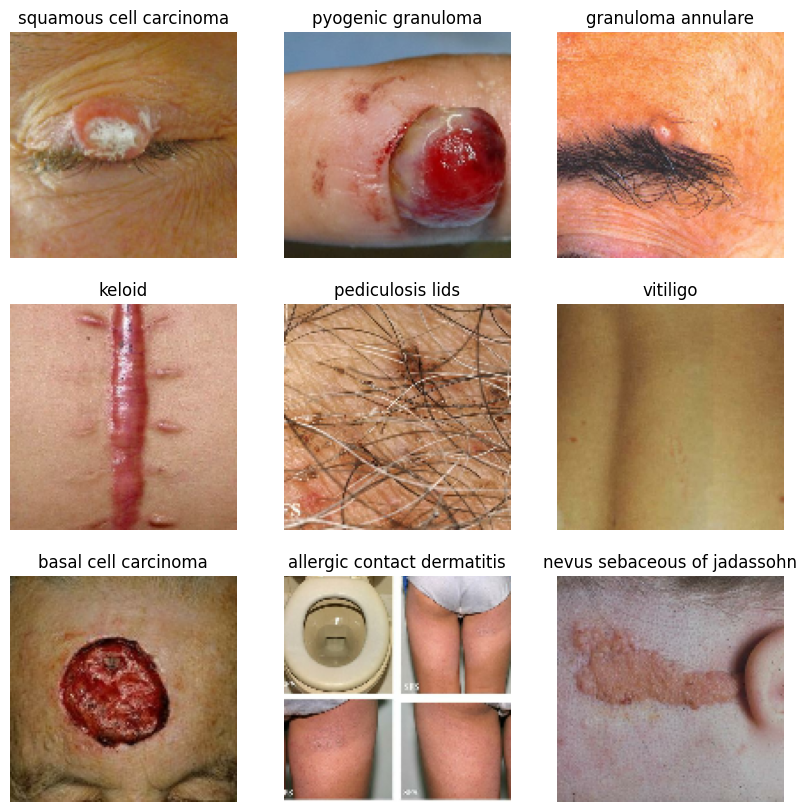

In [15]:
train_data = import_data(batch_size=32, image_size=(128, 128), import_mask=(True, False, False))
SampleVisuals.show_random_sample(train_data, 32)

In [62]:
# ***********************************
# Importing numeric and image data
# ***********************************

def num_data_import(augmented_train_data_,
                    train_data_,
                    val_data_,
                    test_data_,
                    batch_size=None):
    
    num_data=pd.read_csv("fitzpatrick17k.csv")
    train_filenames=[]
    val_filenames=[]
    test_filenames=[]
    for path in train_data_.file_paths:
        filename=os.path.basename(path)
        train_filenames.append(filename)
    for path in val_data_.file_paths:
        filename=os.path.basename(path)
        val_filenames.append(filename)
    for path in test_data_.file_paths:
        filename=os.path.basename(path)
        test_filenames.append(filename)
    
    #removing .jpg string
    train_filenames=list(map(lambda x: x[:-4],train_filenames))
    val_filenames=list(map(lambda x: x[:-4],val_filenames))
    test_filenames=list(map(lambda x: x[:-4],test_filenames))
    
    #getting numerical data from .csv with the filenames
    train_num_d, val_num_d, test_num_d = [], [], []
    for image in train_filenames:
        temp=num_data[['fitzpatrick_scale']][num_data['md5hash']==image].values.tolist()[0]
        train_num_d.append(temp) 
    for image in val_filenames:
        temp=num_data[['fitzpatrick_scale']][num_data['md5hash']==image].values.tolist()[0]
        val_num_d.append(temp)
    for image in test_filenames:
        temp=num_data[['fitzpatrick_scale']][num_data['md5hash']==image].values.tolist()[0]
        test_num_d.append(temp)
    
    #imputing data
    t = pd.DataFrame(train_num_d,columns=["fitz_1"])
    v = pd.DataFrame(val_num_d,columns=["fitz_1"])
    te = pd.DataFrame(test_num_d,columns=["fitz_1"])
    
    t_fitz_mean = np.mean(t, axis=0)
    
    t['fitz_1'] = t['fitz_1'].replace(-1,t_fitz_mean['fitz_1'])
    v['fitz_1'] = v['fitz_1'].replace(-1,t_fitz_mean['fitz_1'])
    te['fitz_1'] = te['fitz_1'].replace(-1,t_fitz_mean['fitz_1'])
    
    #normalizing data
    num_scaler=MinMaxScaler()
    t=pd.DataFrame(num_scaler.fit_transform(t),columns=["fitz_1"])
    v=pd.DataFrame(num_scaler.transform(v),columns=["fitz_1"])
    te=pd.DataFrame(num_scaler.transform(te),columns=["fitz_1"])
       
    #turning the numerical data into a dataset
    train_num_d=tf.data.Dataset.from_tensor_slices(t).batch(batch_size)
    val_num_d=tf.data.Dataset.from_tensor_slices(v).batch(batch_size)
    test_num_d=tf.data.Dataset.from_tensor_slices(te).batch(batch_size)
    
    #zip the datasets
    combined_train_data = tf.data.Dataset.zip((augmented_train_data_, train_num_d))
    combined_val_data = tf.data.Dataset.zip((val_data_, val_num_d))
    combined_test_data = tf.data.Dataset.zip((test_data_, test_num_d))
    
    #restructure the dataset ((image_data,num_data),labels)
    combined_train_data = combined_train_data.map(combine_batch)
    combined_val_data = combined_val_data.map(combine_batch)
    combined_test_data = combined_test_data.map(combine_batch)
    
    return combined_train_data, combined_val_data, combined_test_data

In [63]:
# *********************************
# Defining class weigths
# *********************************

# our dataset shows heavy data imbalance, a first-line measure to combat
# its consequences is to set class weights, i.e. for underrepresented
# classes our model's loss will increase by a factor larger than 1 if
# the expected class is different from the real class, and will increase
# by a factor smaller than 1 for over represented classes

def get_balanced_class_weights(dir_path: str) -> dict:
        
    # also TODO check if we can increase class weights
    # for cancerous diseases
    
    y = []
    for i, dir in enumerate(os.listdir(dir_path)):
        y += [i] * len(os.listdir(os.path.join(dir_path, dir)))
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y) 

    return dict(enumerate(class_weights))
        

# run once don't need to run it again
# regardless of image size or batch size
# or any other the train dataset will
# remain the same
CLASS_WEIGHTS = get_balanced_class_weights(TRAIN_PATH)

In [70]:
# *********************************
# Defining Callbacks
# *********************************

# how to implement custom metric for early stopping callback:
# similar implementation of callback that we want: https://datascience.stackexchange.com/questions/26833/is-there-away-to-change-the-metric-used-by-the-early-stopping-callback-in-keras
# data generator and validation data error: https://stackoverflow.com/questions/61939790/keras-custom-metrics-self-validation-data-is-none-when-using-data-generators
# how to write custom callbacks: https://keras.io/guides/writing_your_own_callbacks/

# NOTES:
# - EarlyStopping: stops early if target metric not increasing
# - ModelCheckpoint: saves model
# - TensorBoard: to visually assess our model's traning
# - ReduceLROnPlateau: reduces LR dynamically

# custom LR scheduler
def lr_schedule(epoch, lr):
    # reducif LR by a factor of 10 every 7 epochs
    if epoch % 7 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr


# to run in a GPU we had to downgrade tensorflow
# the tf version does not have the F1Score metric
# hence we create our own callback
class MacroF1(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
       
        # Predictions on training set
        # y_train_true = []
        # y_train_pred = []
        # for X_batch, y_batch in self.train_data:
        #     y_train_true.extend(np.argmax(y_batch, axis=1))
        #     y_train_pred.extend(np.argmax(self.model.predict(X_batch, verbose=0), axis=1))

        # Predictions on validation set
        y_val_true = []
        y_val_pred = []
        for X_batch, y_batch in self.val_data:
            y_val_true.extend(np.argmax(y_batch, axis=1))
            y_val_pred.extend(np.argmax(self.model.predict(X_batch, verbose=0), axis=1))

        # Calculate F1 score for training set
        # train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
        # Calculate F1 score for validation set
        val_f1 = f1_score(y_val_true, y_val_pred, average='macro')

        # Log the F1 scores
        logs = logs if logs else {}
        logs['f1_score'] = 0.0  # too time consuming to calculate train f1
        logs['val_f1_score'] = val_f1


# the idea here is to abort training if the train and val loss
# drift too far apart
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, patience, verbose=0):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        
        if train_loss is not None and val_loss is not None:
            gap = abs(train_loss - val_loss)
            if gap > self.threshold:
                self.wait += 1
                if self.wait >= self.patience:
                    if self.verbose:
                        print(f"Stopping training as gap ({gap:.4f}) exceeds threshold ({self.threshold:.4f}) for {self.patience} epochs")
                    self.model.stop_training = True
            else:
                self.wait = 0


# list of callbacks
def get_callback_list(model_path: str,
                      *other_callbacks,
                      monitor:str = 'val_loss',
                      early_stop_patience: int = 3) -> list:
    """
    Returns a pre-specified, fixed, callback list
    plus any other custom callbacks added as non-keyword
    arguments.
    
    Args:
        model_path: ModelCheckpoint callback stores model
        to path.
        monitor: Metric to monitor. By default it's 'val_loss'.
        other_callbacks: Other callbacks to include.
    
    Returns:
        List of callbacks.
    """
    
    if other_callbacks:
        other_callbacks = list(other_callbacks)
    else:
        other_callbacks = []
        
    callbacks_list = [
        
        EarlyStopping(monitor=monitor,
                      patience=early_stop_patience,
                      min_delta=0.01,
                      restore_best_weights=True,
                      start_from_epoch=5),
        
        ModelCheckpoint(filepath=model_path,
                        monitor=monitor,
                        save_best_only=True,
                       verbose=1),
        
        TensorBoard(log_dir='log_dir',
                    histogram_freq=1),
        
        ReduceLROnPlateau(monitor=monitor,
                          factor=0.1,
                          patience=2,
                          cooldown=0,
                          verbose=1)
        
    ]

    # NOTE the order matters, the custom callback should be the first
    # in the list otherwise its logs will not be updated between epochs
    # and the other callbacks will not have be able to monitor the custom
    # metric
    return other_callbacks + callbacks_list

In [65]:
# ***************************************
# Saving and loading model histories
# ***************************************

# in case we want to save history to plot loss or
# another metric later on. we can store it as a
# pickle file sending to file

def save_model_history(history, path):
    with open(path, 'wb') as history_pickle:
        pickle.dump(history, history_pickle)

def load_model_history(path):
    with open(path, 'rb') as history_pickle:
        history = pickle.load(history_pickle)
    return history

In [66]:
# *********************************
# Model builder function
# *********************************

# def model_builder(head_model: tf.keras.models.Sequential,
#                   input_shape: tuple,
#                   *,
#                   preprocessing_pipeline: tf.keras.models.Sequential = None,
#                   base_model: tf.keras.models.Sequential = None,
#                   training: bool = False,
#                   multiple_inputs: list[tf.keras.layers.Input] = None,
#                   model_name: str = None) -> tf.keras.Model:
#     """
#     Builds a model using the provided head_model, augmentation_pipeline,
#     base_model, and multiple_inputs.
    
#     Args:
#         head_model: model that takes the output of the base_model
#         base_model: model that takes the augmented image
#         training: boolean that determines whether the base_model
#         will be used for training or inference.
#         multiple_inputs: list of input layers that will be concatenated
#         before being passed to the base_model. If None, only one input
#         layer is used (pre-defined).
    
#     Returns:
#         tf.keras.Model: the final model
#     """
    
#     # input layer
#     if multiple_inputs is None:
#         inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
#     else:
#         inputs = tf.keras.layers.Concatenate(axis=1)(multiple_inputs)
    
#     # preprocessing
#     if preprocessing_pipeline is not None:
#         x = preprocessing_pipeline(inputs)
#     else:
#         x = inputs

#     # base model
#     if base_model is not None:
#         try:
#             x = base_model(x, training=training)
#         except Exception as e:
#             x = base_model(x)
#             print(f'Error: {e}:')
#             print('The base_model is not being used.')
    
#     # adding the head
#     outputs = head_model(x)
    
#     # Creating the final model
#     model = tf.keras.models.Model(inputs=inputs,
#                                   outputs=outputs,
#                                   name=model_name)
    
#     return model


def model_builder(head_model: tf.keras.models.Sequential,
                  input_shape: tuple,
                  num_input_shape: tuple = None,
                  *,
                  preprocessing_pipeline: tf.keras.models.Sequential = None,
                  base_model: tf.keras.models.Sequential = None,
                  num_model: tf.keras.models.Sequential = None,
                  output_layer: tf.keras.models.Sequential = None,
                  training: bool = False,
                  model_name: str = None) -> tf.keras.Model:
    """
    Builds a model using the provided head_model, augmentation_pipeline,
    base_model, and multiple_inputs.
    
    Args:
        head_model: model that takes the output of the base_model
        base_model: model that takes the augmented image
        training: boolean that determines whether the base_model
        will be used for training or inference.
        multiple_inputs: list of input layers that will be concatenated
        before being passed to the base_model. If None, only one input
        layer is used (pre-defined).
    
    Returns:
        tf.keras.Model: the final model
    """
    
    # input layer
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
                 
    # preprocessing
    if preprocessing_pipeline is not None:
        x = preprocessing_pipeline(inputs)
    else:
        x = inputs

    # base model
    if base_model is not None:
        try:
            x = base_model(x, training=training)
        except Exception as e:
            x = base_model(x)
            print(f'Error: {e}:')
            print('The base_model is not being used.')
    
    # adding the head
    outputs = head_model(x)

    # adding multi-input
    if num_input_shape is not None and output_layer is not None:
        
        num_input = tf.keras.layers.Input(shape = num_input_shape, name = 'num_input_layer')
        
        if num_model is None:
            inputs = [inputs, num_input] 
            concat = tf.keras.layers.concatenate([outputs,num_input])
            outputs = output_layer(concat)
        else:
            inputs = [inputs, num_input] 
            num_model = num_model(num_input)
            concat = tf.keras.layers.concatenate([outputs,num_model])
            outputs = output_layer(concat)
        
        
    
    # Creating the final model
    model = tf.keras.models.Model(inputs=inputs,
                                  outputs=outputs,
                                  name=model_name)
    
    return model

In [67]:
# *********************************
# Metrics
# *********************************

METRICS = [
    F1Score(average='macro'),  # use callback instead
    Precision(name='precision'),
    Recall(name='recall'),
    CategoricalAccuracy(name='categorical_accuracy'),
    AUC(name='AUROC')   
]

### **Models**

In [68]:
# *********************************
# Model Dictionary
# *********************************

# In order to predict an images class we need
# ... the fitted model
# ... image size
# ... batch size
# ... preprocessing pipeline (optional - only if we do pp. other than rescaling)
# ... history (not mandatory for prediction but helpful for model evaluation)

In [69]:
# *********************************
# Basic training plot
# *********************************

def plot_loss_history(history: dict,
                      figsize: tuple = (6, 4)) -> None:
        """
        Plots train and validation loss and F1 Score.
        
        Args:
            history: history dictionary returned from
                    tf.keras.model.fit method.
            figsize: figure size. Defaults to (8, 4).
        
        Returns:
            None, it displays and image.
        """

        assert ('loss' in history.keys()) & ('val_loss' in history.keys()),\
               "'loss' and 'val_loss' need to be in history dict."
        
        loss = history['loss']
        val_loss = history['val_loss']

        epochs = range(1, len(loss) + 1)
        plt.figure(figsize=figsize) 
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'bo', label='Validation loss')
        plt.title('Training history')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
# *********************************
# Creating the baseline model
# *********************************

# the idea here is to use a pre-trained model for starters we'll use
# the VGG16 model as used in the paper that first showed the curated
# fitzpatrick17k dataset: same architecture and same data augmentation
# pipeline. This model will serve as a baseline to compare other models.

# useful links:
# - paper: https://arxiv.org/abs/2104.09957
# - code: https://github.com/mattgroh/fitzpatrick17k
# - transfer learning with keras: https://keras.io/guides/transfer_learning/

def baseline_model(model_name: str):
    
    batch_size = 256
    image_size = (256, 256)
    input_shape = image_size + (3,)
    
    train_data, val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(True, True, False))

    base_model = tf.keras.applications.VGG16(
        include_top=True,
        weights="imagenet",
        input_shape=(224, 224, 3)  # must be (224, 224, 3) if include_top=True
    )

    # as per the paper they remove only the last layer (1000 classes)
    base_model = tf.keras.Model(inputs=base_model.input,
                                outputs=base_model.layers[-2].output,
                                name='base_model')

    # freezing the base model
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4, seed=SEED),
        tf.keras.layers.Dense(114),
    ], name='head_model')
    
    # preprocessing pipeline
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(scale=1.0 / stds, offset=-means / stds),
        tf.keras.layers.CentreCrop(224, 224)  # hence input shape of base_model is 224x224
    ], name='preprocessing_pipeline')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          preprocessing_pipeline=preprocessing_pipeline,
                          model_name=model_name)

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # if True do not add final softmax layer
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)

    # augmenting the train data
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', seed=SEED),
        tf.keras.layers.RandomRotation(factor=0.15, seed=SEED)
    ], name='augmentation_pipeline')
    
    augmented_train_data = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))

    history = model.fit(augmented_train_data,
                       epochs=50,
                       validation_data=val_data,
                       class_weight=CLASS_WEIGHTS,
                       callbacks=[LearningRateScheduler(lr_schedule),
                                 ModelCheckpoint(filepath=os.path.join(MODELS_PATH, f'{model_name}.keras'),
                                                   monitor='val_loss',
                                                   save_best_only=True),
                                  MacroF1(augmented_train, val_data)],
                       verbose=1)
    
    return model, history.history


# saving model & history
model_name = baseline_model.__name__
model, history = baseline_model(model_name)
save_model_history(history, os.path.join(HISTORIES_PATH, f'{model_name}.pkl'))
print()
plot_loss_history(history)

In [73]:
# *********************************
# V1 Handcrafted model
# *********************************

def handcrafted_v1(model_name: str):

    batch_size = 16
    image_size = (64, 64)
    input_shape = image_size + (3,)
    
    train_data, val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(True, True, False))

    # from here: https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07
    head_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), strides = 1, padding = 'same'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(64, (3,3), padding = 'same'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
        tf.keras.layers.Dropout(0.2),
    
        tf.keras.layers.Conv2D(128, (3,3), padding = 'same'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Conv2D(256, (3,3), padding = 'same'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Conv2D(512, (3,3), padding = 'same'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(114, activation='softmax'),
    ])

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          model_name=model_name)

    print()
    model.summary()
    print()

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # if True do not add final softmax layer
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)

    # augmenting the train data
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', seed=SEED),
        tf.keras.layers.RandomRotation(factor=0.15, seed=SEED)
    ], name='augmentation_pipeline')
    
    augmented_train_data = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))

    history = model.fit(augmented_train_data,
                       epochs=50,
                       validation_data=val_data,
                       class_weight=CLASS_WEIGHTS,
                       callbacks=[StopTrainingCallback(.3, 5)],
                       verbose=1)
    
    return model, history.history


model_name = handcrafted_v1.__name__
model, history = handcrafted_v1(model_name)
# save_model_history(history, os.path.join(HISTORIES_PATH, f'{model_name}.pkl'))
print()
plot_loss_history(history)

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.

Model: "handcrafted_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 114)               6002482   
                                                                 
Total params: 6002482 (22.90 MB)
Trainable params: 6000498 (22.89 MB)
Non-trainable params: 1984 (7.75 KB)
_________________________________________________________________

Epoch 1/50
723/723 [==============================] - 131s 174ms/step - loss: 5.1625 - f1_score: 0.0074 - precision: 0.0129 - recall: 2.5961e-04 - categorical_accuracy: 0.0082 - AUROC: 0.5188 - val_loss: 4.7584 - val_f1_score: 0.0041 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.0

KeyboardInterrupt: 

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.


Model: "vgg16_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 head_model (Sequential)     (None, 114)               554866    
                                                                 
Total params: 15269554 (58.25 MB)
Trainable params: 554354 (2.11 MB)
Non-trainable params: 14715200 (56.13 MB)
_________________________________________________________________

Epoch 1/50

723/723 [==============================] - 264s 362ms/step - loss: 4.5339 - f1_score: 0.0373 - precision: 0.0326 - recall: 0.0331 - categorical_accuracy: 0.0444 - AUROC: 0.526

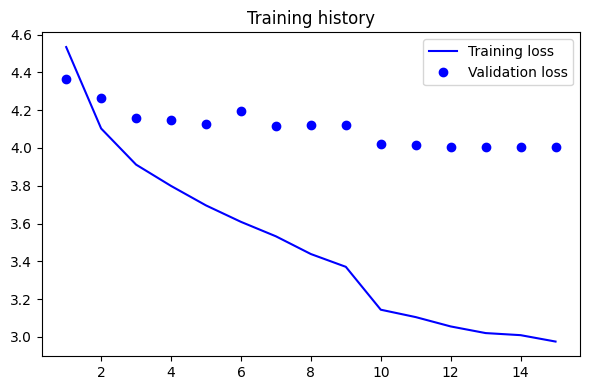

In [46]:
# *********************************
# V1 VGG16 model
# *********************************

def vgg16_v1(model_name: str):

    # NOTES
    # similar to baseline model but
    # ... base model does not include top
    # ... same head model with the excpetion of dropout being switch for batch
    #     normalization(as we first want to see if the model can learn from the data)
    #     the paper on BNorm mentions that this technique can even be used to replace dropout
    # ... much smaller batch size for faster convergence
    # ... much smaller centre crop for manageable training times
    # ... added initializers for reproducibility
    # ... same augmentation and pre processing, compile args, ...
    # ... no centre cropping

    # regarding batch sizes...
    # https://datascience.stackexchange.com/questions/72922/does-small-batch-size-improve-the-model
    # Theory says that, bigger the batch size, lesser is the noise in the gradients
    # and so better is the gradient estimate. This allows the model to take a better
    # step towards a minima. However, the challenge is that bigger batch size needs
    # more memory and each step is time consuming.
    
    batch_size = 16
    image_size = (64, 64)
    input_shape = image_size + (3,)
    
    train_data, val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(True, True, False))  # data already comes rescaled
    
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED), bias_initializer='zeros'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(114, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED), bias_initializer='zeros')
    ], name='head_model')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          model_name=model_name)    
    
    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        'metrics': METRICS
    }
    
    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # augmentation
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', seed=SEED),
        tf.keras.layers.RandomRotation(factor=0.15, seed=SEED)
    ], name='augmentation_pipeline')
    
    augmented_train = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))
    
    # model fitting
    callbacks = get_callback_list(os.path.join(MODELS_PATH, f'{model_name}.keras'))
    history = model.fit(augmented_train,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=callbacks,
                        verbose=1)
    
    return model, history.history


model_name = vgg16_v1.__name__
model, history = vgg16_v1(model_name)
save_model_history(history, os.path.join(HISTORIES_PATH, f'{model_name}.pkl'))
print()
plot_loss_history(history)

In [ ]:
# *********************************
# V2 VGG16 model
# *********************************

# unfreezing layers

In [ ]:
# *********************************
# V3 VGG16 model
# *********************************

# fine tuning / progressive unfreezing

In [ ]:
def multi_VGG16():
    
    batch_size = 32
    image_size = (224, 224)
    input_shape = image_size + (3,)
    num_input_shape=(1,)
    
    train_data, val_data, test_data = import_data(batch_size=batch_size, image_size=image_size)

    base_model = tf.keras.applications.VGG16(
        include_top=True,
        weights="imagenet",
        input_shape=input_shape  # must be (224, 224, 3) if include_top=True
    )

    # as per the paper they remove only the last layer (1000 classes)
    base_model = tf.keras.Model(inputs=base_model.input,
                                outputs=base_model.layers[-2].output,
                                name='multi_VGG16')

    # freezing the base model
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4, seed=42)
    ], name='head_model')
    

    # multi layers net
    
    # Nothing yet, testing direct plug of numerical inputs into output layer.

    
    # preprocessing pipeline
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255)
    ], name='preprocessing_pipeline')

    # Output layer (needs to be specified directly to model_builder for
    # multiclass to work. Do not add it in head_model).
    output_layer=tf.keras.layers.Dense(114)

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          num_input_shape,
                          base_model=base_model,
                          output_layer=output_layer,
                          preprocessing_pipeline=preprocessing_pipeline)

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # if True do not add final softmax layer
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)

    # augmenting the train data
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
        tf.keras.layers.RandomRotation(factor=0.15, seed=42),
        tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, seed=42),
        tf.keras.layers.RandomContrast(factor=0.15, seed=42)
    ], name='augmentation_pipeline')
    
    augmented_train_data = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))

    # add numerical data to dataset
    train_data, val_data, test_data = num_data_import(augmented_train_data, train_data, val_data, test_data,batch_size=batch_size)

    history = model.fit(train_data,
                       epochs=50,
                       validation_data=val_data,
                       class_weight=CLASS_WEIGHTS,
                       callbacks=[LearningRateScheduler(lr_schedule)],
                       verbose=1)
    
    return model, history.history


# saving model & history
# model_name = multi_VGG16.__name__
# model, history = multi_VGG16()
# model.save(os.path.join('model_dir', f'{model_name}.keras'))
# save_model_history(history.history, f'{model_name}.pkl')

In [ ]:
# *********************************
# Xception model
# *********************************

def xception_v1(model_name: str):
    
    batch_size = 256
    image_size = (128, 128)
    input_shape = image_size + (3,)
    
    train_data, val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(True, True, False))
    
    base_model = tf.keras.applications.Xception(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.BatchNormalization(),
	    tf.keras.layers.Activation("relu"),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(114, activation='softmax',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed = SEED),  bias_initializer='zeros')
    ], name='head_model')
    

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          model_name=model_name)

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # augmentation
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(seed=SEED),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=SEED),
        tf.keras.layers.RandomRotation(factor=0.3, seed=SEED),
        tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=SEED)
    ], name='augmentation_pipeline')
    
    augmented_train = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))
    
    # model fitting  
    history = model.fit(augmented_train,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=[EarlyStopping(patience=5),
                                   ModelCheckpoint(filepath=os.path.join('model_dir', 'models', f'{model_name}.keras'),
                                                   monitor='val_loss',
                                                   save_best_only=True)],
                        verbose=1)
    
    return model, history.history

In [ ]:
# *********************************
# ResNet50V2 model
# *********************************

def resnet50v2_v1(model_name: str):
    
    batch_size = 256
    image_size = (128, 128)
    input_shape = image_size + (3,)
    
    train_data, val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(True, True, False))
    
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.BatchNormalization(),
	    tf.keras.layers.Activation("relu"),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(114, activation='softmax',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),  bias_initializer='zeros')
    ], name='head_model')
    

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          model_name=model_name)

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # augmentation
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomRotation(factor=0.3),
        tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
    ], name='augmentation_pipeline')
    
    augmented_train = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))
    
    # model fitting  
    history = model.fit(augmented_train,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=[EarlyStopping(patience=5),
                                   ModelCheckpoint(filepath=os.path.join('model_dir', 'models', f'{model_name}.keras'),
                                                   monitor='val_loss',
                                                   save_best_only=True)],
                        verbose=1)
    
    return model, history.history

In [ ]:
# *********************************
# InceptionResnetV2 model
# *********************************

def inceptionResnetV2(model_name: str):
    
    batch_size = 256
    image_size = (128, 128)
    input_shape = image_size + (3,)
    
    train_data, val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(True, True, False))
    
    base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.BatchNormalization(),
	    tf.keras.layers.Activation("relu"),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(114, activation='softmax',
                              kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),  bias_initializer='zeros')
    ], name='head_model')
    
    # pre processing   
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255),  # normalizing
    ], name='preprocessing_pipeline')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          preprocessing_pipeline=preprocessing_pipeline,
                          model_name=model_name)

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # augmentation
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomRotation(factor=0.3),
        tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
    ], name='augmentation_pipeline')
    
    augmented_train = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))
    
    # model fitting  
    history = model.fit(augmented_train,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=[EarlyStopping(patience=5),
                                   ModelCheckpoint(filepath=os.path.join('model_dir', 'models', f'{model_name}.keras'),
                                                   monitor='val_loss',
                                                   save_best_only=True)],
                        verbose=1)
    
    return model, history.history


model_name = inceptionResnetV2.__name__
model, history = inceptionResnetV2(model_name)
save_model_history(history, os.path.join(HISTORIES_PATH, f'{model_name}.pkl'))
plot_loss_history(history)

In [ ]:
# *****************************
# Vision Transformer
# *****************************

# trying ViT architecture: https://keras.io/examples/vision/image_classification_with_vision_transformer/

def vit(model_name):
    pass


In [ ]:
# *********************************
# Tensorboard
# *********************************

# run:
!tensorboard --logdir=log_dir --host localhost --port 6006
# go to: http://localhost:6006/
# 'interrupt' this cell once you are done

### **Hyper-parameter Tuning**

In [ ]:
def model_builder_hpt(hp = None,
                  input_shape: tuple = None,
                  num_input_shape: tuple = None,
                  compile_kwargs = None,
                  units = None,
                  lr = None,
                  *,
                  preprocessing_pipeline: tf.keras.models.Sequential = None,
                  base_model: tf.keras.models.Sequential = None,
                  num_model: tf.keras.models.Sequential = None,
                  output_layer: tf.keras.models.Sequential = None,
                  training: bool = False,
                  model_name: str = None) -> tf.keras.Model:
    """
    Builds a model using the provided head_model, augmentation_pipeline,
    base_model, and multiple_inputs. It can build a model for fitting data
    or it can build a hyper_model for HPT with keras_tuner.
    
    Args:
        head_model: model that takes the output of the base_model
        base_model: model that takes the augmented image
        training: boolean that determines whether the base_model
        will be used for training or inference.
        multiple_inputs: list of input layers that will be concatenated
        before being passed to the base_model. If None, only one input
        layer is used (pre-defined).
    
    Returns:
        tf.keras.Model: the final model
    """

########################################################################
    
    hp_units = hp.Int('dense_hpt', 
                    min_value = units[0], 
                    max_value = units[1],
                    step = units[2])

    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Dense(hp_units, name='dense_hpt'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4, seed=42),
        tf.keras.layers.Dense(114)
    ], name='head_model')

#######################################################################

    # input layer
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
                 
    # preprocessing
    if preprocessing_pipeline is not None:
        x = preprocessing_pipeline(inputs)
    else:
        x = inputs

    # base model
    if base_model is not None:
        try:
            x = base_model(x, training=training)
        except Exception as e:
            x = base_model(x)
            print(f'Error: {e}:')
            print('The base_model is not being used.')
    
    if lr is not None:
        compile_kwargs['optimizer'].learning_rate.assign(hp.Choice('lr',lr))
    
    # adding the head
    outputs = head_model(x)

    # adding multi-input
    if num_input_shape is not None and output_layer is not None:
        
        num_input = tf.keras.layers.Input(shape = num_input_shape, name = 'num_input_layer')
        
        if num_model is None:
            inputs = [inputs, num_input] 
            concat = tf.keras.layers.concatenate([outputs,num_input])
            outputs = output_layer(concat)
        else:
            inputs = [inputs, num_input] 
            num_model = num_model(num_input)
            concat = tf.keras.layers.concatenate([outputs,num_model])
            outputs = output_layer(concat)
        
        
    
    # Creating the final model
    model = tf.keras.models.Model(inputs=inputs,
                                  outputs=outputs,
                                  name=model_name)

    model.compile(**compile_kwargs)

    return model

In [ ]:
def hpt_VGG16():
    
    batch_size = 32
    image_size = (224, 224)
    input_shape = image_size + (3,)
    num_input_shape=(2,)
    
    train_data, val_data, test_data = import_data(batch_size=batch_size, image_size=image_size)

    base_model = tf.keras.applications.VGG16(
        include_top=True,
        weights="imagenet",
        input_shape=input_shape  # must be (224, 224, 3) if include_top=True
    )

    # as per the paper they remove only the last layer (1000 classes)
    base_model = tf.keras.Model(inputs=base_model.input,
                                outputs=base_model.layers[-2].output,
                                name='multi_VGG16')

    # freezing the base model
    base_model.trainable = False

    # preprocessing pipeline
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255)
    ], name='preprocessing_pipeline')


    compile_kwargs = {
    'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
    'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # if True do not add final softmax layer
    'metrics': METRICS
    }

    #define search space
    units=[100,400,20]  # [min_number, max_number, step]
    lr=[0.001,0.002,0.003] # [list of possible values]

    # create the hyper_model by isolating the hp parameter
    hyper_model = partial(model_builder_hpt,
                          input_shape=input_shape,
                          num_input_shape=None,
                          compile_kwargs=compile_kwargs,
                          units=units,
                          lr=lr,
                          base_model=base_model,
                          num_model=None,
                          output_layer=None,
                          training=False,
                          model_name='Hyper',
                          preprocessing_pipeline=preprocessing_pipeline)

    #model_builder_hpt(hp = None,
                      #input_shape: tuple = None,
                      #num_input_shape: tuple = None,
                      #compile_kwargs = None,
                      #units = None,
                      #lr = None,
                      #*,
                      #preprocessing_pipeline: tf.keras.models.Sequential = None,
                      #base_model: tf.keras.models.Sequential = None,
                      #num_model: tf.keras.models.Sequential = None,
                      #output_layer: tf.keras.models.Sequential = None,
                      #training: bool = False,
                      #model_name: str = None) -> tf.keras.Model:

    # augmenting the train data
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
        tf.keras.layers.RandomRotation(factor=0.15, seed=42),
        tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, seed=42),
        tf.keras.layers.RandomContrast(factor=0.15, seed=42)
    ], name='augmentation_pipeline')
    
    augmented_train_data = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))

    tuner = kt.Hyperband(hyper_model, 
                         #objective=kt.Objective("val_MacroF1", direction="max"),
                         objective='val_loss',
                         max_epochs=15,
                         factor=4,
                         directory=os.path.join('model_dir','htp'),
                         project_name="grid_VGG16")

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(augmented_train_data,
                   epochs=50,
                   validation_data=val_data,
                   class_weight=CLASS_WEIGHTS,
                   callbacks=[stop_early],
                   verbose=1)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    return best_hps


# saving model & history
model_name = hpt_VGG16.__name__
best_hps=hpt_VGG16()
print(best_hps)

### **Model Evaluation**

In [59]:
# quick check: which models do we have?

print(os.listdir(MODELS_PATH))

['vgg16_v1.keras', 'vgg16_v2.keras']


In [60]:
# *********************************
# Creating model dict
# *********************************

# NOTES:
# 1. all models must have unique names
# 2. model names in model dir and pickle names in history dir should be the same, e.g. baseline.keras and baseline.pkl
# 3. (ideally) all model histories share the same metrics
# 4. all models should be saved as .keras

model_names = ['vgg16_v1']  # manually or list comprehension like [name.split('.')[0] for name in os.listdir(MODELS_PATH)]
model_dict = {}
for name in model_names:
    print(f'Loading {name}...')
    model_dict[name] = {'model': load_model(os.path.join('model_dir', 'models', f'{name}.keras')),
                        'history': load_model_history(os.path.join('model_dir', 'history', f'{model_name}.pkl'))}


# we need to know how was the data imported:
# for each model in model_dict we need to provide
# the image size and batch size (batch size itself
# is not needed to make predictions but boost efficiency)
# as well as the pre processing steps

model_dict['vgg16_v1']['image_size'] = (64, 64)
model_dict['vgg16_v1']['batch_size'] = 16
model_dict['vgg16_v1']['preprocessing'] = None

# ... repeat this process for all other models in model_dict

Loading vgg16_v1...


In [52]:
# *****************************
# Comparing models
# *****************************

def compare_models(histories: Union[dict, list[dict]],
                   *,
                   names: Union[str, list[str]] = 'Model',
                   metrics: Union[list[tuple], tuple] = ('loss', 'val_loss')):
    """
    Plots the training and validation history of one or more models.

    Args:
        histories: A dictionary or a list of dictionaries containing the training and validation
        history of the models. Each dictionary should have the metrics as keys and the corresponding values as lists.
        names: The names of the models. It can be a single string or a list of strings.
        Defaults to 'Model'.
        metrics: The metrics to plot. It can be a single tuple or a list of tuples.
        Each tuple should contain two strings representing the training metric and the validation metric.
        Defaults to ('loss', 'val_loss').

    Raises:
        ValueError: If no histories are provided or if the metrics argument is not a list or a tuple.
        ValueError: If the histories do not share the same metrics.

    Returns:
        None
    """
    if not histories:
        raise ValueError('No histories to plot.')

    if isinstance(histories, dict):
        histories = [histories]

    if isinstance(names, str):
        names = [names] * len(histories)

    if isinstance(metrics, tuple):
        metrics = [metrics]
    elif not isinstance(metrics, list):
        raise ValueError('metrics must be a list or a tuple.')

    # all histories must share the same metrics
    u_metrics = set([metric for pair in metrics for metric in pair])
    if not all(set(hist.keys()).issuperset(u_metrics) for hist in histories):
        raise ValueError('Histories must share the same metrics.')

    # for each metric pair (train, val) we want to plot, on the same plot
    # the history of each model for that pair of metrics
    for i, (train_metric, val_metric) in enumerate(metrics):
        
        # ax1 for train, ax2 for val
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
        fig.suptitle(f'{train_metric} and {val_metric} History')

        # plotting train metrics
        for j, history in enumerate(histories):
            ax1.plot(history[train_metric], label=f'{names[j]}')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel(train_metric)
            ax1.legend(loc="upper right")
            ax1.grid(True)

        # plotting val metrics
        for k, history in enumerate(histories):
            ax2.plot(history[val_metric], label=f'{names[k]}')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel(val_metric)
            ax2.legend(loc="upper right")
            ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

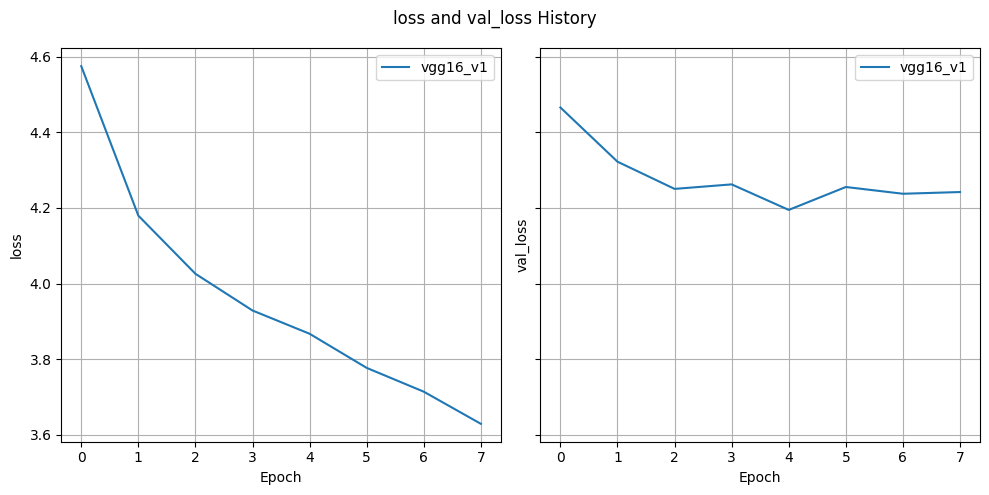

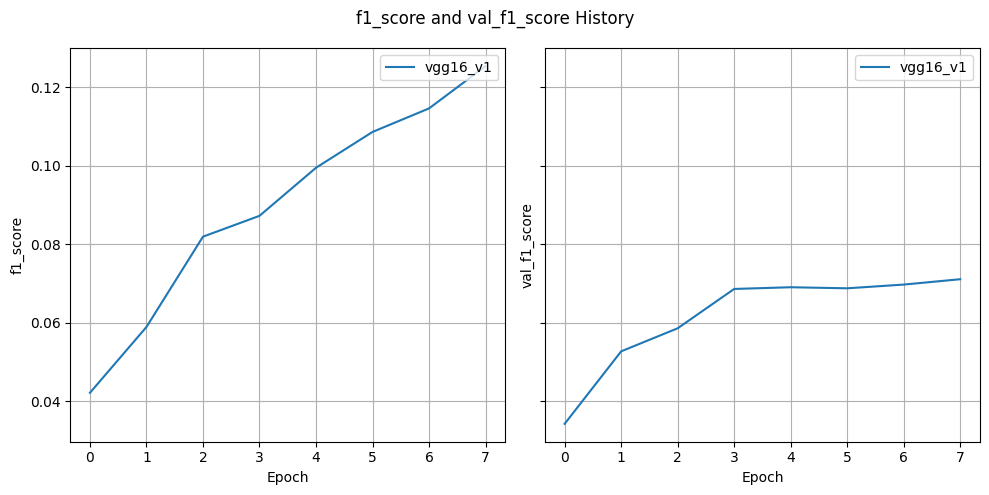

In [62]:
# BEST MODEL SO FAR:
# Preprocessing: Rescaling(1./255)
# Base model: VGG16 (include_top=False)
# Head model: Dense(256), Activation('relu'), Dropout(0.4), Dense(114)
# Data augmentation: RandomFlip(mode='horizontal'), RandomRotation(factor=0.15), RandomZoom(height_factor=0.15, width_factor=0.15), RandomContrast(factor=0.15)
# Optimizer: Adam(learning_rate=0.01)
# Loss: CategoricalCrossentropy(from_logits=True)
# Batch size: 32
# Image size: (128, 128) RGB

names, histories = [], []
for name in model_dict:
    model_info = model_dict[name]
    history = model_info['history']
    names.append(name); histories.append(history)

compare_models(histories,
               names=names,
               metrics=[('loss', 'val_loss'),
                        ('f1_score', 'val_f1_score')])

# val loss increasing but f1 score and accuracy increasing as well?! https://stats.stackexchange.com/questions/282160/how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy

In [95]:
# **********************************
# validation classification reports
# **********************************

for name in model_dict:
    model_info = model_dict[name]
    model = model_info['model']
    batch_size = model_info['batch_size']
    image_size = model_info['image_size']
    preprocessing = model_info['preprocessing']

    val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(False, True, False))
    if preprocessing is not None:
        val_data = val_data.map(lambda x, y: (preprocessing(x, training=False), y))
    X_val = np.array([x for batch_x, _ in val_data for x in batch_x])
    y_val_true = np.array([np.argmax(y) for _, batch_y in val_data for y in batch_y])

    results = model.evaluate(X_val, y_val_true, batch_size=128)

# WTF... model getting better results if we don't rescale data??

Found 2477 files belonging to 114 classes.
78/78 [==============================] - 27s 341ms/step
Classification Report for vgg16_v1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        28
           2       0.12      0.06      0.08        50
           3       1.00      0.00      0.00         9
           4       0.09      0.14      0.11        14
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        64
           7       0.05      0.18      0.07        11
           8       0.11      0.09      0.10        70
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         9
          11       0.06      0.10      0.08        10
          12       0.00      0.00      0.00        12
          13       0.06      0.12      0.08        16
          14       0.10      0.40      0.15        10


Found 2477 files belonging to 114 classes.
78/78 [==============================] - 26s 337ms/step


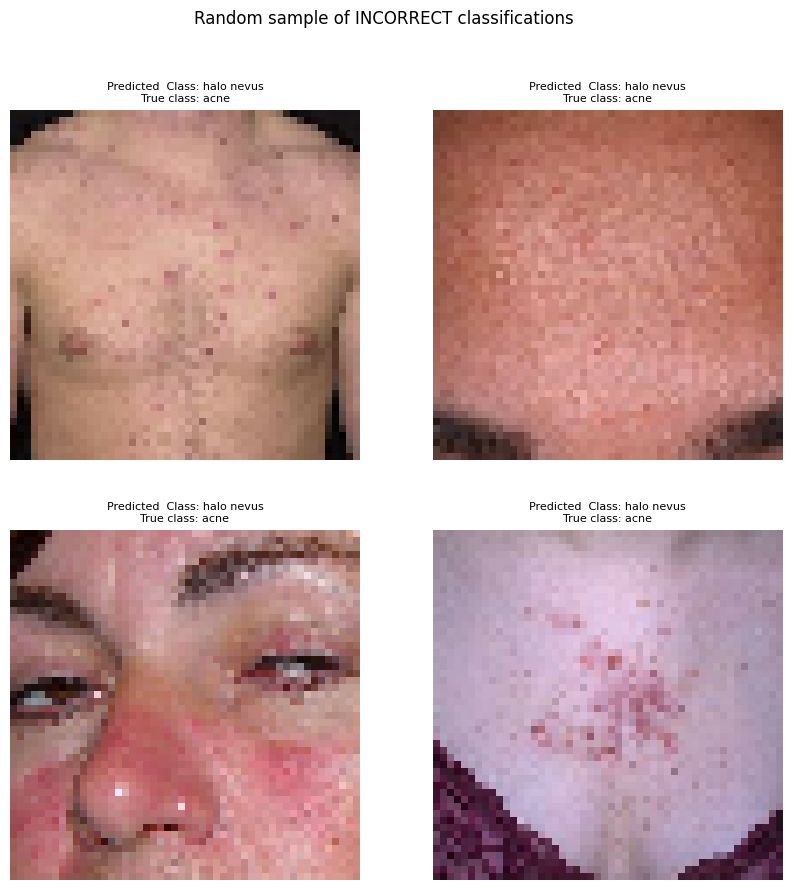

In [79]:
# **********************************
# Sample of prediction results
# **********************************

# the idea here is to show a sample of the
# images that our model got wrong (or right)
# to quickly and roughly assess the model's
# prediction quality

for name in model_dict:
    model_info = model_dict[name]
    model = model_info['model']
    batch_size = model_info['batch_size']
    image_size = model_info['image_size']
    preprocessing = model_info['preprocessing']

    val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(False, True, False))
    val_data = val_data.map(lambda x, y: (preprocessing(x, training=False), y))
    X_val = np.array([x for batch_x, _ in val_data for x in batch_x])
    y_val_true = np.array([np.argmax(y) for _, batch_y in val_data for y in batch_y])
    y_val_pred = np.argmax(model.predict(X_val, verbose=1), axis=1)

    ModelVisualEvaluation.plot_prediction_sample(X_val, y_val_true,
                                                 y_val_pred, show_class=1,
                                                 only_show_wrong=True,
                                                 grid_size=(2,2))

# TODO: maybe use this in conjunction with grad cam??

In [96]:
# **********************************
# Benign vs. malign classification
# **********************************

# our main objective is to predict a class on a set of 114
# possible classes. Nonetheless, we believe that we also can
# and should assess our model's performance, as first-line metric,
# based on whether is it predicting correctly if the skin disease
# presented is benign or malign.

def convert_to_binary_classification_mode(y_true: np.ndarray, y_pred: np.ndarray,
                                          malign_disease_map: dict = MALIGN_DISEASES) -> tuple[np.ndarray]:
    """
    Converts the multi-class classification into a binary classification
    mode. The idea is to map all the classes that are malign into a single
    class and all the others into another class.
    
    Args:
        y_true: true labels
        y_pred: predicted labels
        malign_disease_map: dict mapping malign diseases to their respective class
        
    Returns:
        tuple: y_true_bin, y_pred_bin
    """
    mapper = lambda arr: [malign_disease_map[i] for i in arr]
    y_true_bin = mapper(y_true)
    y_pred_bin = mapper(y_pred)
    return (y_true_bin, y_pred_bin)


for name in model_dict:
    model_info = model_dict[name]
    model = model_info['model']
    batch_size = model_info['batch_size']
    image_size = model_info['image_size']
    preprocessing = model_info['preprocessing']

    val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(False, True, False))
    val_data = val_data.map(lambda x, y: (preprocessing(x, training=False), y))
    X_val = np.array([x for batch_x, _ in val_data for x in batch_x])
    y_val_true = np.array([np.argmax(y) for _, batch_y in val_data for y in batch_y])
    y_val_pred = np.argmax(model.predict(X_val, verbose=1), axis=1)

    y_val_bin_true, y_val_bin_pred = convert_to_binary_classification_mode(y_val_true, y_val_pred)
    print(f'Classification Report for {name}:')
    print(classification_report(y_val_bin_true, y_val_bin_pred, zero_division=1))

Found 2477 files belonging to 114 classes.
78/78 [==============================] - 29s 366ms/step
Classification Report for vgg16_v1:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2138
           1       1.00      0.00      0.00       339

    accuracy                           0.86      2477
   macro avg       0.93      0.50      0.46      2477
weighted avg       0.88      0.86      0.80      2477



In [97]:
# **********************************
# Top-5 Accuracy
# **********************************

# this is a common metric to assess the performance
# of models in multi-class classification problems.
# It is the proportion of times the true class is in
# the top-5 predicted classes.

def top_5_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Computes the top-5 accuracy.
    
    Args:
        y_true: true labels
        y_pred: predicted labels, one hot encoded
        (proba. for each class)
        
    Returns:
        float: top-5 accuracy
    """
    top_5 = np.argsort(y_pred, axis=1)[:, -5:]
    top_5 = np.array([i in j for i, j in zip(y_true, top_5)])
    return np.mean(top_5)


print('Top-5 accuracy scores:')
for name in model_dict:
    model_info = model_dict[name]
    model = model_info['model']
    batch_size = model_info['batch_size']
    image_size = model_info['image_size']
    preprocessing = model_info['preprocessing']

    val_data = import_data(batch_size=batch_size, image_size=image_size, import_mask=(False, True, False))
    val_data = val_data.map(lambda x, y: (preprocessing(x, training=False), y))
    X_val = np.array([x for batch_x, _ in val_data for x in batch_x])
    y_val_true = np.array([np.argmax(y) for _, batch_y in val_data for y in batch_y])
    y_val_pred_ohe = model.predict(X_val, verbose=1)

    top5_acc = top_5_accuracy(y_val_true, y_val_pred_ohe)
    print(f'\t{name}: {top5_acc}')

Top-5 accuracy scores:
Found 2477 files belonging to 114 classes.
78/78 [==============================] - 26s 332ms/step
	vgg16_v1: 0.025030278562777553


In [ ]:
# **********************************
# Predictions on test set
# **********************************



In [ ]:
# **********************************
# Evaluation on skin types
# **********************************

# TODO: redo this as a 'bonus' for testing 

# the idea here is to check whether our
# model is biased towards a specific skin
# type.

# steps:
# 1. get the skin type of each image
# 2. get the true and predicted labels
# 3. get the confusion matrix for each skin type

# NOTE use non-shuffled data

CSV_DATA = pd.read_csv('data/fitzpatrick17k.csv')

def map_img_path_to_skin_type(img_path: str) -> str:
    # parse img path to get hash
    img_hash = os.path.split(img_path)[-1][:-4]
    # get skin type
    skin_type = CSV_DATA.loc[CSV_DATA['md5hash'] == img_hash, 'fitzpatrick_scale'].values[0]
    return skin_type

instances_per_skin_type = {}
correct_predictions_per_skin_type = {}
for true_label, pred_label, img_path in zip(y_val_true, y_val_pred, val_data.file_paths):
    skin_type = map_img_path_to_skin_type(img_path)
    if skin_type not in instances_per_skin_type:
        instances_per_skin_type[skin_type] = 0
        correct_predictions_per_skin_type[skin_type] = 0
    instances_per_skin_type[skin_type] += 1
    if true_label == pred_label:
        correct_predictions_per_skin_type[skin_type] += 1

# confusion matrix per skin type
# for skin_type in instances_per_skin_type:
#     print(f'Skin Type: {skin_type}')
#     print(f'Instances: {instances_per_skin_type[skin_type]}')
#     print(f'Correct Predictions: {correct_predictions_per_skin_type[skin_type]}')
#     print(f'Accuracy: {correct_predictions_per_skin_type[skin_type] / instances_per_skin_type[skin_type]}')
#     print()

# plotting accuracy by skin type
skin_types = list(instances_per_skin_type.keys())
accuracies = [correct_predictions_per_skin_type[skin_type] / instances_per_skin_type[skin_type] for skin_type in skin_types]
avg_accuracy = np.mean(accuracies)
plt.bar(x=skin_types, height=accuracies)
plt.axhline(y=avg_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {avg_accuracy:.2f}')
plt.legend()
plt.show()